In [1]:
import string
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from numpy.fft import fft2, ifft2
from KDtree import KDTree, Rectangle

In [2]:
def draw_multiline_text(text, size=(800, 600), font='arial', show=False):
    offset_x = size[0] // 5
    offset_y = size[1] // 5
    center = (size[0] // 2, size[1] // 2)
    img = Image.new("RGB", size, (255, 255, 255))
    d = ImageDraw.Draw(img)

    l = 5
    r = 100
    while l <= r:
        s = (l + r) // 2
        fnt = ImageFont.truetype(f"fonts/{font}.ttf", s)
        upper_x, upper_y, lower_x, lower_y = d.multiline_textbbox(center, text, anchor='mm', font=fnt)
        if (upper_x > offset_x and lower_x < size[0] - offset_x
            and upper_y > offset_y and lower_y < size[1] - offset_y):
            l = s + 1
        else:
            r = s - 1

    font_size = r
    fnt = ImageFont.truetype(f"fonts/{font}.ttf", font_size)
    d.multiline_text(center, text, anchor='mm', font=fnt, fill=(0, 0, 0))
    if show:
        display(img)
    return img, font_size

In [3]:
def remove_black_padding(img):
    matrix = np.array(img)
    matrix[:, :np.argmax(matrix[0])] = 255
    return Image.fromarray(matrix)

def draw_single_character(char, font_size, font='arial', show=False):
    img = Image.new("L", (200, 200), 255)
    d = ImageDraw.Draw(img)
    fnt = ImageFont.truetype(f"fonts/{font}.ttf", font_size)
    w = d.textbbox((0, 0), char, font=fnt)
    d.text((0, 0), char, font=fnt, fill=0)
    img = img.crop(w)
    if char == 'j':
        img = remove_black_padding(img)
    if show:
        display(img)
    return img

In [4]:
def rotate_image(img, angle):
    return img.rotate(angle, fillcolor=(255, 255, 255), resample=Image.BICUBIC)

In [5]:
char_a = draw_single_character('j', 99, font='open-sans')
display(char_a)

In [6]:
out, f_size = draw_multiline_text('''
In all chaotic beauty lies a wounded work of art.
Beautiful but torn, wreaking havoc on my heart.
Camouflaged by insecurities, blinded by it all.
I love the way you sit there and barely notice me at all.
''', font='open-sans')

In [7]:
def get_all_character(font, fontsize):
    characters = string.ascii_lowercase + ".,?!"
    return list(map(lambda x: draw_single_character(x, fontsize, font), characters))


In [8]:
def img_to_matrix(img):
    img = img.convert('L')
    return np.array(img)

def matrix_to_image(matrix):
    return Image.fromarray(matrix)

def invert_colors(matrix):
    return 255 - matrix

def convolve_images(pattern, image):
    s = (max(pattern.shape[0], image.shape[0]), max(pattern.shape[1], image.shape[1]))
    return np.abs(ifft2(fft2(pattern[::-1, ::-1], s=s) * fft2(image, s=s)))

def normalize(matrix):
    return 255 * (matrix / np.max(matrix))

def threshold_matrix(matrix, k=150):
    black = matrix < k
    white = matrix >= k
    matrix[black] = 0
    matrix[white] = 255
    return matrix


In [9]:
def reduce_noise(img, k = 80):
    matrix = img_to_matrix(img)
    U, S, V = np.linalg.svd(matrix)
    mat = U[:, :k] @ np.diag(S[:k]) @ V[:k, :]
    return matrix_to_image(normalize(mat)).convert('L')


In [10]:
def count_lines(img):
    matrix = invert_colors(threshold_matrix(img_to_matrix(img)))
    matrix = np.sum(matrix, axis=1)
    return matrix.shape[0] - np.count_nonzero(matrix)

def count_something(img):
    matrix = invert_colors(threshold_matrix(img_to_matrix(img)))
    rows = np.argmax(matrix[:, ::-1], axis=1)
    cols = np.argmax(matrix[::-1, :], axis=0)
    return 3*np.sum(rows) + np.sum(cols)

def upside_down(img):
    return count_something(img) < count_something(rotate_image(img, 180))

def correct_angle(img):
    best_angle = 0
    best_score = 0
    for i in range(180):
        rotated = rotate_image(img, i)
        if (score := count_lines(rotated)) > best_score:
            best_score = score
            best_angle = i

    img = rotate_image(img, best_angle)
    if upside_down(img):
        return rotate_image(img, 180)
    return img


In [11]:
def ocr(image, font, font_size, i=8):
    image = reduce_noise(image)
    chars = get_all_character(font, font_size)
    char_arrays = list(map(img_to_matrix, chars))
    char_arrays = list(map(invert_colors, char_arrays))

    matrix = img_to_matrix(image)
    matrix = invert_colors(matrix)

    convolution = convolve_images(char_arrays[i], matrix)
    max_correlation = np.max(convolve_images(char_arrays[i], char_arrays[i]))

    display(Image.fromarray(char_arrays[i]))

    new_array = np.array(image.convert('RGB'))
    a, b = char_arrays[i].shape
    red = (255, 0, 0)

    count = 0
    points = []
    for i, j in zip(*np.where(np.abs(convolution - max_correlation) < 0.05*max_correlation)):
        points.append((i, j))
        new_array[i:i-a:-1, j] = red
        new_array[i:i-a:-1, j - b] = red
        new_array[i, j:j-b:-1] = red
        new_array[i - a, j:j-b:-1] = red
        count += 1

    display(Image.fromarray(new_array))
    return points

In [12]:
def correlation_matrix(font, font_size):
    chars = get_all_character(font, font_size)
    char_arrays = list(map(img_to_matrix, chars))
    char_arrays = list(map(invert_colors, char_arrays))
    norms = np.sqrt(np.array([np.max(convolve_images(i, i)) for i in char_arrays]))
    pairs = list(zip(char_arrays, norms))
    correlation = np.array([[np.max(convolve_images(i, j) / (i_norm * j_norm)) for i, i_norm in pairs] for j, j_norm in pairs])
    print(np.round(correlation[8], 2))
    return correlation

In [14]:
# correlation_matrix('open-sans', 12)

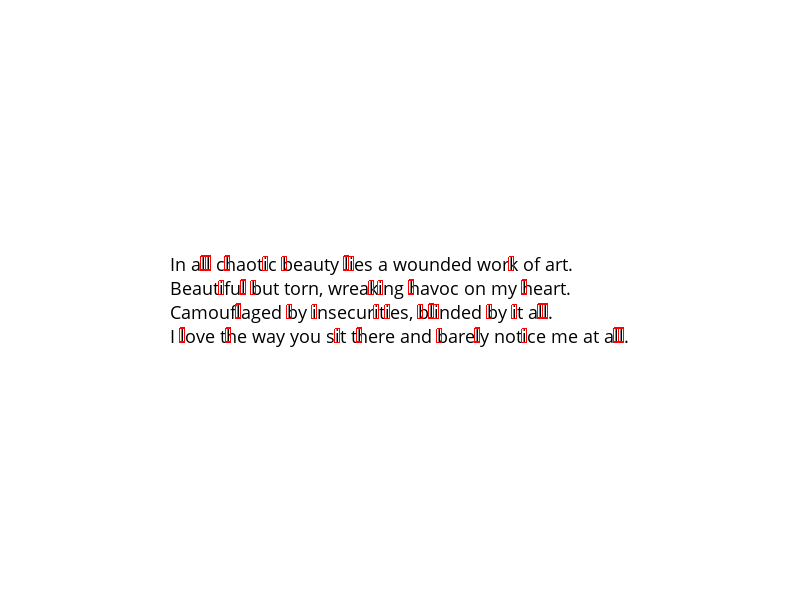

In [15]:
points_s = ocr(out, 'open-sans', f_size)

In [16]:
print(points_s)

[(269, 205), (269, 210), (269, 229), (269, 348), (270, 205), (270, 210), (270, 229), (270, 267), (270, 286), (270, 348), (270, 353), (270, 513), (293, 245), (293, 413), (293, 526), (294, 223), (294, 245), (294, 255), (294, 373), (294, 382), (294, 413), (294, 526), (317, 240), (317, 433), (317, 542), (317, 547), (318, 240), (318, 291), (318, 316), (318, 378), (318, 389), (318, 422), (318, 433), (318, 438), (318, 491), (318, 516), (318, 542), (318, 547), (341, 184), (341, 230), (341, 361), (341, 479), (341, 618), (341, 623), (342, 184), (342, 230), (342, 339), (342, 361), (342, 441), (342, 479), (342, 526), (342, 618), (342, 623)]


In [17]:
tree = KDTree(points_s)

In [19]:
tree.build_kd()